vae1　オートエンコーダー (batch_norm含む)

参考文献　我妻幸長　「はじめてのディープラーニング２」

In [ ]:
#　colaboraory用: Google drive をマウントする
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# colaboratory用: フォルダを移る
%cd "drive/My Drive/Colab Notebooks/"

/content/drive/My Drive/Colab Notebooks


フォルダは自分の指定のものに変更して下さい。

In [ ]:
%cd "ctorch210929/MiniCTorch_Prototype/notebook"

/content/drive/My Drive/Colab Notebooks/ctorch210929/MiniCTorch_Prototype/notebook


In [ ]:
! pip install lark-parser

     |████████████████████████████████| 103 kB 5.5 MB/s 


In [ ]:
import sys
sys.path.append("../")

import json
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import minictorch.generator as GN
import minictorch.converter as CV

サンプルデータ

In [ ]:
import torch.utils as utils
from torchvision import datasets, transforms
from sklearn import datasets

img_size = 8
n_in = img_size * img_size
n_mid = 16
n_out = n_in
n_z = 2
n_batch = 32

digits_data = datasets.load_digits()
dd = np.asarray( digits_data.data, dtype=np.float32 )
dd /= 15
x_train = torch.from_numpy( dd ).clone()
t_train = digits_data.target
print(x_train.shape)

torch.Size([1797, 64])


サンプルデータの図化

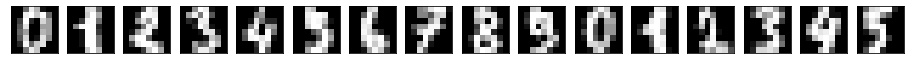

In [ ]:
import matplotlib.pyplot as plt
n_img = 16

plt.figure( figsize=(16,3))
for i in range(n_img):
  ax = plt.subplot(3,n_img,i+1)
  plt.imshow(dd[i].reshape(img_size,-1).tolist(),cmap="Greys_r")
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

ニューラルネットワークの定義

In [ ]:
"""
def reconstruction( y, t ):
  eps = 1.0e-7
  e = t * torch.log(y+eps) + (1-t) * torch.log(1-y+eps) 
  z = torch.sum(e) / len(y)
  return z;

def kl_divergence( mean, log_var ):
  g = 1 + log_var - mean**2 - torch.exp( log_var )
  y = 0.5 * torch.sum( g ) / len(mean)
  return y
"""

import torch.distributions as tdist

class Net(torch.nn.Module):
  def __init__( self, n_in, n_mid, n_out, n_z, e ):
    super(Net, self).__init__()
    self.fc1 = nn.Linear(n_in, n_mid)
    self.bn1 = nn.BatchNorm1d(n_mid, momentum=0.1)
    self.fc2_mean = nn.Linear(n_mid, n_z)
    self.fc2_var  = nn.Linear(n_mid, n_z)
    self.fc3 = nn.Linear(n_z  ,n_mid)
    self.fc4 = nn.Linear(n_mid,n_out)
    #self.drop1 = nn.Dropout(p=0.2)
    self.eps = e

    """
    nn.init.constant_(self.fc1.bias,0)
    nn.init.constant_(self.fc2_mean.bias,0)
    nn.init.constant_(self.fc2_var.bias,0)
    nn.init.constant_(self.fc3.bias,0)
    nn.init.constant_(self.fc4.bias,0)
    """
  
  def forward( self, x ):

    # encoder
    self.x1 = F.relu( self.fc1(x) )
    self.x2 = self.bn1( self.x1 )
    self.mean    = self.fc2_mean( self.x2 )
    self.log_var = self.fc2_var( self.x2 )

    # reparametrization
    #eps = torch.randn( n_batch, n_z )
    eps = torch.randn( self.mean.shape )
    #print("mean",self.mean.size(),self.mean)
    #nm = tdist.Normal( 0.0, 1.0 ) #torch.tensor([0.0]), torch.tensor([1.0]))
    #eps = nm.sample([ n_batch, n_z ])
    #eps = torch.normal(0.0,1.0,[32,2])
    #print("eps",eps.size(),eps)
    self.z = self.mean + eps * torch.exp( 0.5 * self.log_var )
    #self.z = self.mean + self.eps * torch.exp( 0.5 * self.log_var )

    # decoder
    self.y2 = F.relu( self.fc3(self.z) )
    #self.y2 = self.drop1(self.y1)
    y = torch.sigmoid( self.fc4(self.y2) )
    self.out = y 
    
    e1 = reconstruction( y, x )
    e2 = kl_divergence( self.mean, self.log_var )
    #print("e1,e2",e1,e2)

    self.loss1=e1
    self.loss2=e2
    return -(e1+e2)

In [ ]:
def generate_json( json_path, input, e ):

    model = Net( n_in, n_mid, n_out, n_z, e )

    model.eval()
    with torch.no_grad():
        print("[SAVE]", json_path )
        GN.generate_minictorch_file( model, input, json_path )

    return model

In [ ]:
torch.manual_seed( 1 )

project = 'vae1bn'
json_path = './network/' + project +'.json'

x = x_train.clone().detach()
torch.reshape( x, (-1,n_in) )

x = x[0:n_batch,:]
#print(type(x))
x.requires_grad = True

# eps for check
e = torch.randn( n_batch, 2 )
print("eps",e)

model = generate_json( json_path, x, e )

eps tensor([[-1.5256, -0.7502],
        [-0.6540, -1.6095],
        [-0.1002, -0.6092],
        [-0.9798, -1.6091],
        [-0.7121,  0.3037],
        [-0.7773, -0.2515],
        [-0.2223,  1.6871],
        [ 0.2284,  0.4676],
        [-0.6970, -1.1608],
        [ 0.6995,  0.1991],
        [ 0.8657,  0.2444],
        [-0.6629,  0.8073],
        [ 1.1017, -0.1759],
        [-2.2456, -1.4465],
        [ 0.0612, -0.6177],
        [-0.7981, -0.1316],
        [ 1.8793, -0.0721],
        [ 0.1578, -0.7735],
        [ 0.1991,  0.0457],
        [ 0.1530, -0.4757],
        [-0.1110,  0.2927],
        [-0.1578, -0.0288],
        [ 2.3571, -1.0373],
        [ 1.5748, -0.6298],
        [-0.9274,  0.5451],
        [ 0.0663, -0.4370],
        [ 0.7626,  0.4415],
        [ 1.1651,  2.0154],
        [ 0.1374,  0.9386],
        [-0.1860, -0.6446],
        [ 1.5392, -0.8696],
        [-3.3312, -0.7479]])
bn1_r_mean tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
bn1_r_var  tens

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: TracerWarning: Using len to get tensor shape might cause the trace to be incorrect. Recommended usage would be tensor.shape[0]. Passing a tensor of different shape might lead to errors or silently give incorrect results.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: TracerWarning: Using len to get tensor shape might cause the trace to be incorrect. Recommended usage would be tensor.shape[0]. Passing a tensor of different shape might lead to errors or silently give incorrect results.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/torch/jit/_trace.py:985: TracerWarning: Trace had nondeterministic nodes. Did you forget call .eval() on your model? Nodes:
	%eps : Float(32, 2, strides=[2, 1], requires_grad=0, device=cpu) = aten::randn(%161, %162, %163, %164, %165) # <ipython-input-11-b3c37f4a0f15>:48:0
This may cause errors in trace checking. To disab

skip: Net/Linear[fc1]/weight/242
skip: Net/Linear[fc1]/weight/242
skip: Net/BatchNorm1d[bn1]/weight/247
skip: Net/BatchNorm1d[bn1]/weight/247
skip: Net/BatchNorm1d[bn1]/weight/247
skip: Net/BatchNorm1d[bn1]/weight/247
skip: Net/Linear[fc2_mean]/weight/250
skip: Net/Linear[fc2_mean]/weight/250
skip: Net/Linear[fc2_var]/weight/253
skip: Net/Linear[fc2_var]/weight/253
skip: Net/Linear[fc3]/weight/256
skip: Net/Linear[fc3]/weight/256
skip: Net/Linear[fc4]/weight/259
skip: Net/Linear[fc4]/weight/259


In [ ]:
CV.convert_json( project, "./src", model, x, json_path )

[JSON] ./network/vae1bn.json
{'name': 'Net/Linear[fc1]/weight/273', 'op': 'prim::GetAttr', 'in': [], 'output_id': 0, 'shape': [], 'out': [3], 'sorted_id': 1}
{'name': 'Net/Linear[fc1]/bias/272', 'op': 'prim::GetAttr', 'in': [], 'output_id': 0, 'shape': [], 'out': [3], 'sorted_id': 2}
{'name': 'Net/BatchNorm1d[bn1]/weight/282', 'op': 'prim::GetAttr', 'in': [], 'output_id': 0, 'shape': [], 'out': [13], 'sorted_id': 5}
{'name': 'Net/BatchNorm1d[bn1]/bias/281', 'op': 'prim::GetAttr', 'in': [], 'output_id': 0, 'shape': [], 'out': [13], 'sorted_id': 6}
{'name': 'Net/BatchNorm1d[bn1]/running_mean/280', 'op': 'prim::GetAttr', 'in': [], 'output_id': 0, 'shape': [], 'out': [13], 'sorted_id': 7}
{'name': 'Net/BatchNorm1d[bn1]/running_var/279', 'op': 'prim::GetAttr', 'in': [], 'output_id': 0, 'shape': [], 'out': [13], 'sorted_id': 8}
{'name': 'Net/Linear[fc2_mean]/weight/285', 'op': 'prim::GetAttr', 'in': [], 'output_id': 0, 'shape': [], 'out': [16], 'sorted_id': 14}
{'name': 'Net/Linear[fc2_mean]

In [ ]:
# check code
with torch.set_grad_enabled(True):
  model.train()
  output = model( x )
  print("output",output)
  output.backward()
  #print("output",output.grad)
  
  print("bn1_w_grad",model.bn1.weight.grad)
  print("bn1_b_grad",model.bn1.bias.grad)
  print("bn1_r_mean",model.bn1.running_mean)
  print("bn1_r_var ",model.bn1.running_var)
  print("bn1_r_mom ",model.bn1.momentum)
  print("input_grad",x.grad)

bn1_r_mean1 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
bn1_r_var1  tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
output tensor(45.4276, grad_fn=<NegBackward>)
bn1_w_grad tensor([ 0.0681,  0.0943,  0.1852,  0.0268,  0.0691, -0.0281, -0.0142,  0.0099,
         0.0383, -0.0063, -0.0059,  0.1957,  0.1781,  0.0483,  0.0183,  0.0096])
bn1_b_grad tensor([-0.1183,  0.1815,  0.0916,  0.1584,  0.2382,  0.1021, -0.2388,  0.0572,
        -0.1788,  0.0037,  0.0009,  0.2123, -0.2162, -0.2023, -0.1121, -0.0047])
bn1_r_mean tensor([1.9344e-02, 3.5760e-03, 4.1789e-02, 9.5197e-03, 4.4271e-03, 5.1183e-03,
        7.3245e-03, 6.3666e-05, 2.3782e-02, 2.2501e-04, 2.7088e-02, 6.0839e-03,
        2.7233e-03, 1.5992e-02, 2.5597e-03, 1.0245e-02])
bn1_r_var  tensor([0.9013, 0.9003, 0.9027, 0.9013, 0.9007, 0.9008, 0.9012, 0.9000, 0.9032,
        0.9000, 0.9019, 0.9013, 0.9003, 0.9032, 0.9002, 0.9027])
bn1_r_mom  0.1
input_grad tensor([[-0.0083,  0.0134, -0.

In [ ]:
!g++ -std=c++14 ./src/vae1bn.cpp ./src/vae1bn_param.cpp -D_NOTEBOOK -I ../../../xtensor -lcblas -o ./src/vae1bn

In [ ]:
!./src/vae1bn

### forward computation ...
ndim=2
{ 45.444004}
### backward computation ...
input_grad{{-0.007507,  0.003278, -0.014397, ..., -0.001978, -0.010346,  0.003978},
 {-0.027707, -0.065583,  0.005144, ...,  0.010182, -0.044462, -0.020182},
 {-0.020915, -0.063428, -0.017768, ...,  0.007662, -0.037721, -0.013324},
 ..., 
 {-0.007586, -0.003597, -0.014099, ..., -0.010423, -0.019605, -0.001289},
 {-0.005328,  0.002133, -0.009461, ..., -0.004136, -0.00761 ,  0.002362},
 { 0.000742, -0.018651, -0.002838, ..., -0.001917, -0.022699, -0.009447}}


学習の実行(python)

In [ ]:
torch.manual_seed( 1 )

epochs = 500
batch_size = 32
#interval = 5  # 経過の表示間隔

e = torch.randn( batch_size, 2 )
#print("eps",e)

net = Net( n_in, n_mid, n_out, n_z, e )
net.train()

lr = 0.001
type=1
if type==1:
  opt = torch.optim.SGD(net.parameters(), lr)
  #opt = torch.optim.Adagrad(net.parameters(), lr)
if type==2:  # for test
  opt = torch.optim.Adam(net.parameters(), lr )

epoch_loss1 = []
epoch_loss2 = []

rec_error_record = []
reg_error_record = []
total_error_record = []
n_batch = len(x_train) // batch_size  # 1エポックあたりのバッチ数
print("batch",n_batch,len(x_train),batch_size)

for i in range(epochs):
        
    # -- 学習 -- 
    index_random = np.arange(len(x_train))
    np.random.shuffle(index_random)  # インデックスをシャッフルする

    total_loss = 0.0
    for j in range(n_batch):
        
        # ミニバッチを取り出す
        mb_index = index_random[ j*batch_size : (j+1)*batch_size ]
        x_mb = x_train[mb_index, :]
        x_mb.requires_grad = True
        #print("x_mb",x_mb.shape)
        
        # 順伝播と逆伝播
        loss = net( x_mb )
        #print("loss",loss)
        total_loss += loss;

        opt.zero_grad()
        loss.backward()
        
        # 重みとバイアスの更新
        opt.step()
        #print("EPOCH: {} {} loss: {}".format(i,j, loss))

    # -- 誤差を求める --
    print("EPOCH: {} loss: {}".format(i, total_loss))
    #epoch_loss.append( total_loss )

    x2 = x_train.clone().detach()
    torch.reshape( x2, (-1,n_in) )
    #print(x2.shape)

    net.eval()
    loss = net( x2 )
    print("loss",loss,net.loss1,net.loss2)
    
    if type==1:
      epoch_loss1.append( loss )
    if type==2:
      epoch_loss2.append( loss )

batch 56 1797 32
EPOCH: 0 loss: 2526.101318359375
loss tensor(44.2531, grad_fn=<NegBackward>) tensor(-44.0037, grad_fn=<DivBackward0>) tensor(-0.2494, grad_fn=<DivBackward0>)
EPOCH: 1 loss: 2437.05322265625
loss tensor(42.8725, grad_fn=<NegBackward>) tensor(-42.5753, grad_fn=<DivBackward0>) tensor(-0.2972, grad_fn=<DivBackward0>)
EPOCH: 2 loss: 2362.179443359375
loss tensor(41.3924, grad_fn=<NegBackward>) tensor(-40.8425, grad_fn=<DivBackward0>) tensor(-0.5499, grad_fn=<DivBackward0>)
EPOCH: 3 loss: 2272.07568359375
loss tensor(39.5239, grad_fn=<NegBackward>) tensor(-38.3689, grad_fn=<DivBackward0>) tensor(-1.1550, grad_fn=<DivBackward0>)
EPOCH: 4 loss: 2149.25341796875
loss tensor(37.2128, grad_fn=<NegBackward>) tensor(-35.3260, grad_fn=<DivBackward0>) tensor(-1.8869, grad_fn=<DivBackward0>)
EPOCH: 5 loss: 2023.4549560546875
loss tensor(34.9747, grad_fn=<NegBackward>) tensor(-32.7206, grad_fn=<DivBackward0>) tensor(-2.2540, grad_fn=<DivBackward0>)
EPOCH: 6 loss: 1913.5538330078125
los

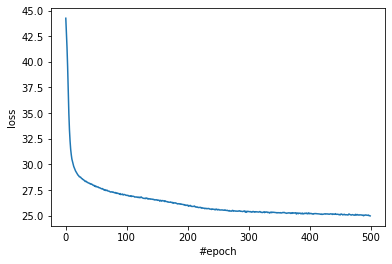

In [ ]:
fig = plt.figure()
ax = fig.add_subplot()
if type==1:
  ax.plot(list(range(len(epoch_loss1))), epoch_loss1)
if type==2:
  ax.plot(list(range(len(epoch_loss2))), epoch_loss2)
ax.set_xlabel('#epoch')
ax.set_ylabel('loss')
fig.show()

O (1797, 64)


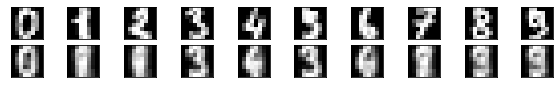

In [ ]:


n_img2=10
#x3=x[:n_img2]
x2 = x_train.clone().detach()
x3=x2[:n_img2]

torch.reshape( x2, (-1,n_in) )

loss = net( x2 )

o = net.out.to('cpu').detach().numpy().copy()
print("O",o.shape)

plt.figure( figsize=(10,2))
for i in range(n_img2):
  #input image
  ax = plt.subplot(3,n_img2,i+1)
  plt.imshow( x3[i].reshape(img_size,-1).tolist(),cmap="Greys_r")
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  #output image
  ax = plt.subplot(3,n_img2,i+1+n_img2)
  plt.imshow( o[i].reshape(img_size,-1).tolist(),cmap="Greys_r")
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

plt.show()

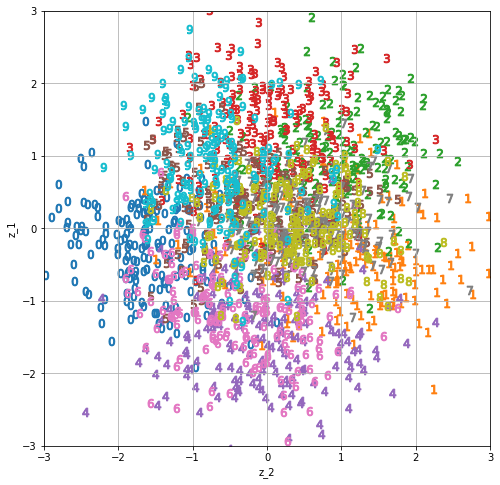

In [ ]:
t2 = t_train #[:n_batch]

x2 = x_train.clone().detach()
torch.reshape( x2, (-1,n_in) )
loss = net( x2 )

plt.figure(figsize=(8,8))
for i in range(10):
  zt = net.z[t2==i]
  z_1 = zt[:,0]
  z_2 = zt[:,1]
  marker= "$"+str(i)+"$"
  plt.scatter(z_2.tolist(), z_1.tolist(), marker=marker,s=75)

plt.xlabel("z_2")
plt.ylabel("z_1")
plt.xlim(-3,3)
plt.ylim(-3,3)
plt.grid()
plt.show()

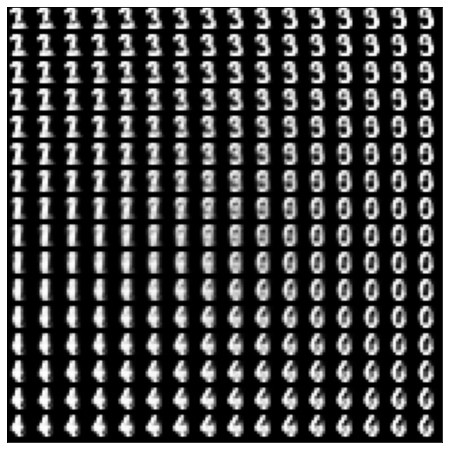

In [ ]:
n_img3=16
img_size_spaced = img_size + 2
matrix_image = np.zeros(( img_size_spaced*n_img3, img_size_spaced*n_img3 ))

z_1 = np.linspace( 3, -3, n_img3 )
z_2 = np.linspace( 3, -3, n_img3 )

with torch.set_grad_enabled(False):
  for i, z1 in enumerate(z_1):
    for j,z2 in enumerate(z_2):

      z = np.array([z1, z2])
      zz = torch.from_numpy( z ).float()
      
      y = F.relu( net.fc3(zz) )
      o = torch.sigmoid( net.fc4(y) )
      image = o.reshape(img_size, img_size)
      top  = i * img_size_spaced
      left = j * img_size_spaced
      matrix_image[top:top+img_size, left:left+img_size] = image

plt.figure(figsize=(8,8))
plt.imshow( matrix_image.tolist(), cmap="Greys_r" )
plt.tick_params( labelbottom=False, labelleft=False, bottom=False, left=False )
plt.show()

学習の実行(C++)

In [ ]:
!g++ -std=c++14 ./src/vae1bn.cpp ./src/vae1bn_param.cpp ./src/vae1bn_train.cpp ./src/vae1_data.cpp -D_NOTEBOOK -I ../../../xtensor -lcblas -o ./src/vae1bn_train

In [ ]:
!./src/vae1bn_train

indata shape 1797,64
batch number 56,32
epoch_num : 200
total_loss 0 loss-2222.54
epoch 0 - loss { 33.225239} ( {-32.518253} , {-0.706986} ) 
total_loss 1 loss-1709.21
epoch 1 - loss { 29.063627} ( {-28.058596} , {-1.005031} ) 
total_loss 2 loss-1611.02
epoch 2 - loss { 28.283035} ( {-27.450575} , {-0.832461} ) 
total_loss 3 loss-1575.19
epoch 3 - loss { 27.93396 } ( {-27.165972} , {-0.767989} ) 
total_loss 4 loss-1556.01
epoch 4 - loss { 27.577969} ( {-26.870556} , {-0.707412} ) 
total_loss 5 loss-1537.05
epoch 5 - loss { 27.228436} ( {-26.546265} , {-0.682171} ) 
total_loss 6 loss-1521.77
epoch 6 - loss { 27.041763} ( {-26.295309} , {-0.746455} ) 
total_loss 7 loss-1509.2
epoch 7 - loss { 26.834728} ( {-26.136208} , {-0.69852 } ) 
total_loss 8 loss-1498.38
epoch 8 - loss { 26.706858} ( {-25.996727} , {-0.710131} ) 
total_loss 9 loss-1493.67
epoch 9 - loss { 26.578018} ( {-25.834129} , {-0.743889} ) 
total_loss 10 loss-1487.13
epoch 10 - loss { 26.469751} ( {-25.674641} , {-0.795111} 

c++ からの出力ファイルの読み込み

In [ ]:
#load out file
f = open('./src/vae1bn.out', 'r')

epoch_loss = []
datalist = f.readlines()
for data in datalist:
  #print(data)
  epoch_loss.append( float(data) )

f.close()

print("epoch =", len(epoch_loss))
print( epoch_loss)

# load pred file
f2 = open('./src/vae1bn.pred', 'r')

datalist = f2.readlines()

n1 = 10
n2 = 64
k = 0
for data in datalist:
  ds = data.split(',')
  if k==0:
    n1 = int(ds[0])
    n2 = int(ds[1])
    global v_pred
    v_pred = np.zeros( (n1,n2))
  else:
    for i in range(n2):
      v_pred[k-1,i] = float(ds[i])
  k = k+1

f2.close()

print("pred =", n1,n2 )
#print( y_pred )

# load z file
f3 = open('./src/vae1bn.z', 'r')

datalist = f3.readlines()
n1 = 100
n2 = 2
k = 0
for data in datalist:
  ds = data.split(',')
  if k==0:
    nz1 = int(ds[0])
    nz2 = int(ds[1])
    z_pred = np.zeros( (nz1,nz2))
  else:
    z_pred[k-1,0] = float(ds[0])
    z_pred[k-1,1] = float(ds[1])
  k = k+1

f3.close()

print("z =", nz1,nz2 )
#print(z_pred)

epoch = 200
[33.225239, 29.063627, 28.283035, 27.93396, 27.577969, 27.228436, 27.041763, 26.834728, 26.706858, 26.578018, 26.469751, 26.328859, 26.267879, 26.144466, 26.017443, 25.950771, 25.790813, 25.753092, 25.701935, 25.642241, 25.5606, 25.554003, 25.469099, 25.494007, 25.448984, 25.43465, 25.324057, 25.375954, 25.379723, 25.341379, 25.357197, 25.336845, 25.348846, 25.33025, 25.304432, 25.242744, 25.321922, 25.260517, 25.244431, 25.250498, 25.23868, 25.183937, 25.225504, 25.213615, 25.181213, 25.244976, 25.180801, 25.186106, 25.150608, 25.142212, 25.181004, 25.161688, 25.178495, 25.095221, 25.118359, 25.077154, 25.096443, 25.107, 25.065403, 25.074232, 25.059582, 25.034998, 25.040499, 25.03508, 24.982092, 25.024618, 24.949739, 24.963648, 24.92989, 24.94533, 24.911287, 24.895756, 24.914415, 24.894342, 24.867729, 24.857153, 24.83555, 24.79376, 24.799843, 24.783283, 24.714367, 24.734247, 24.723846, 24.676693, 24.677353, 24.602312, 24.608809, 24.67363, 24.642588, 24.655704, 24.590019, 2

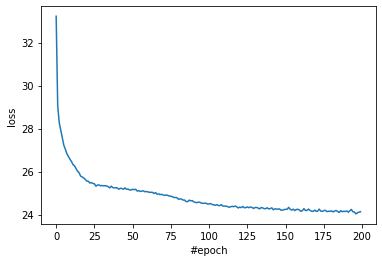

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot()
ax.plot(list(range(len(epoch_loss))), epoch_loss)
ax.set_xlabel('#epoch')
ax.set_ylabel('loss')
fig.show()

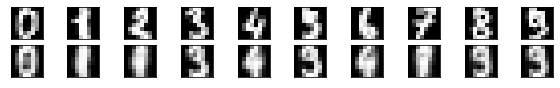

In [ ]:
n_img5 = 10
x2 = x[:n_img5]

plt.figure( figsize=(10,2))
for i in range(n_img5):
  # input image
  ax = plt.subplot(3,n_img5,i+1)
  plt.imshow( x2[i].reshape(img_size,-1).tolist(),cmap="Greys_r")
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # output image
  ax = plt.subplot(3,n_img5,i+1+n_img5)
  plt.imshow( v_pred[i].reshape(img_size,-1).tolist(),cmap="Greys_r")
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

plt.show()

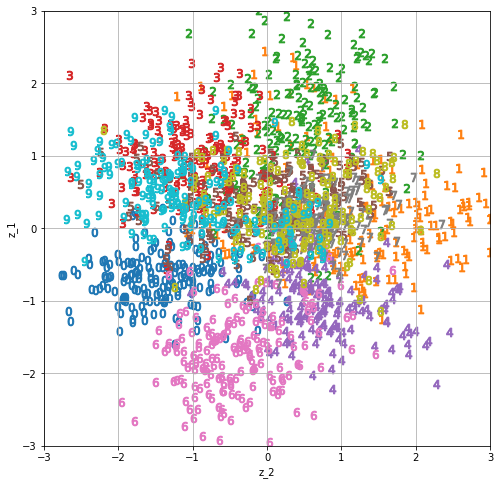

In [ ]:
t2 = t_train #[:n_batch]

plt.figure(figsize=(8,8))
for i in range(10):
  zt = z_pred[t2==i]
  z_1 = zt[:,0]
  z_2 = zt[:,1]
  marker= "$"+str(i)+"$"
  plt.scatter( z_2.tolist(),  z_1.tolist(), marker=marker,s=75 )

plt.xlabel("z_2")
plt.ylabel("z_1")
plt.xlim(-3,3)
plt.ylim(-3,3)
plt.grid()
plt.show()